In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import st_remux as st

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



%matplotlib inline

Using TensorFlow backend.
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/trial_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/trial_env/l

In [2]:
# Config
highpath = 'EMG_data/high_fatigue_raw.csv'
lowpath = 'EMG_data/low_fatigue_raw.csv'

fs = 4000
win_len = 40

use_filter = 0   # weird results if we use python filtering

use_matlab_backend = 0

high = np.genfromtxt(highpath, delimiter=',')
low = np.genfromtxt(lowpath, delimiter=',')


In [3]:
if use_matlab_backend:
    print('Using MATLAB signal processing backend')
    # high_dir = 'datasets/high/'
    # low_dir = 'datasets/low/'

    high_dir = 'EMG_data/power_spectrum_for_cnn_input/high/'
    low_dir = 'EMG_data/power_spectrum_for_cnn_input/low/'

    def generate_3darray(directory):
        files = os.listdir(directory)
        dims = np.genfromtxt(directory + files[0], delimiter=',').shape
        length = len(files)
        arr = np.zeros((length, dims[0], dims[1]))

        for idx, val in enumerate(files):
            arr[idx] = np.genfromtxt(directory + val, delimiter=',')

        return arr

    hi = generate_3darray(high_dir)
    lo = generate_3darray(low_dir)
    
else: 
    print('Using native backend')
    hi = st.raw_to_arr(high, fs, win_len, 0)
    lo = st.raw_to_arr(low, fs, win_len, 0)

X = np.concatenate((hi, lo))

hi_Y = np.ones(len(hi), dtype=int)
lo_Y = np.zeros(len(lo), dtype=int)

Y = np.concatenate((hi_Y, lo_Y))

Using native backend


In [4]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1, random_state=13)

In [5]:
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Testing data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (3681, 16, 40) (3681,)
Testing data shape:  (410, 16, 40) (410,)


In [6]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs: ', nClasses)
print('Output classes: ', classes)


Total number of outputs:  2
Output classes:  [0 1]


Text(0.5,1,'Ground Truth: 1')

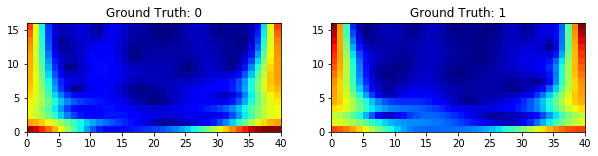

In [7]:
plt.figure(figsize=[10,2])

# Display first image in training set
plt.subplot(121)
plt.pcolormesh(train_X[0,:,:], cmap='jet')
plt.title("Ground Truth: {}".format(train_Y[0]))

# Display second image in testing set
plt.subplot(122)
plt.pcolormesh(test_X[1], cmap='jet')
plt.title("Ground Truth: {}".format(test_Y[1]))

In [8]:
ydim = train_X[0].shape[0]
xdim = train_X[0].shape[1]
train_X = train_X.reshape(-1, ydim, xdim, 1)
test_X = test_X.reshape(-1, ydim, xdim, 1)
train_X.shape, test_X.shape

((3681, 16, 40, 1), (410, 16, 40, 1))

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [10]:
# Change labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# See the difference?
print('Original label: ', train_Y[0])
print('After conversion to one-hot: ', train_Y_one_hot[0])

Original label:  0
After conversion to one-hot:  [1. 0.]


In [11]:
train_Y_one_hot.shape

(3681, 2)

In [12]:
# Partition data for 80% training and 20% validation
# should reduce overfitting and boost test performance

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2)

train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((2944, 16, 40, 1), (737, 16, 40, 1), (2944, 2), (737, 2))

In [13]:
# let's get down to business
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [14]:
batch_size = 256
epochs = 50
num_classes = nClasses

In [15]:
emg_model = Sequential()
emg_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(ydim, xdim, 1)))
emg_model.add(BatchNormalization())

emg_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
emg_model.add(BatchNormalization())
emg_model.add(MaxPooling2D(pool_size=(2, 2)))
emg_model.add(Dropout(0.25))

emg_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emg_model.add(BatchNormalization())
emg_model.add(Dropout(0.25))

emg_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emg_model.add(BatchNormalization())
emg_model.add(MaxPooling2D(pool_size=(2, 2)))
emg_model.add(Dropout(0.4))

emg_model.add(Flatten())

"""emg_model.add(Dense(512, activation='relu'))
emg_model.add(BatchNormalization())
emg_model.add(Dropout(0.3))"""

emg_model.add(Dense(128, activation='relu'))
emg_model.add(BatchNormalization())
emg_model.add(Dropout(0.3))

emg_model.add(Dense(2, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
emg_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [17]:
emg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 38, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 38, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 36, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 36, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 18, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 18, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 16, 64)        

In [18]:
history_emg = emg_model.fit(train_X,train_label,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_X, valid_label))

Instructions for updating:
Use tf.cast instead.
Train on 2944 samples, validate on 737 samples
Epoch 1/50
2944/2944 [==============================] - 8s 3ms/step - loss: 0.6902 - accuracy: 0.7177 - val_loss: 0.6930 - val_accuracy: 0.5034
Epoch 2/50
2944/2944 [==============================] - 4s 1ms/step - loss: 0.4072 - accuracy: 0.8519 - val_loss: 0.6930 - val_accuracy: 0.5020
Epoch 3/50
2944/2944 [==============================] - 4s 2ms/step - loss: 0.3284 - accuracy: 0.8862 - val_loss: 0.7073 - val_accuracy: 0.4966
Epoch 4/50
2944/2944 [==============================] - 4s 1ms/step - loss: 0.2645 - accuracy: 0.9073 - val_loss: 0.7539 - val_accuracy: 0.4966
Epoch 5/50
2944/2944 [==============================] - 4s 1ms/step - loss: 0.2402 - accuracy: 0.9209 - val_loss: 0.8315 - val_accuracy: 0.4966
Epoch 6/50
2944/2944 [==============================] - 4s 1ms/step - loss: 0.2257 - accuracy: 0.9239 - val_loss: 1.0093 - val_accuracy: 0.4966
Epoch 7/50
2944/2944 [===================

KeyboardInterrupt: 